In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("un.csv")
df.head

<bound method NDFrame.head of       session  year country  country_name                            speaker  \
0          25  1970     ALB       Albania                            Mr. NAS   
1          25  1970     ARG     Argentina                 Mr. DE PABLO PARDO   
2          25  1970     AUS     Australia                        Mr. McMAHON   
3          25  1970     AUT       Austria                 Mr. KIRCHSCHLAEGER   
4          25  1970     BEL       Belgium                         Mr. HARMEL   
...       ...   ...     ...           ...                                ...   
7502       70  2015     YEM         Yemen  Mr. Abdrabuh Mansour Hadi Mansour   
7503       70  2015     YUG    Yugoslavia               Mr. Tomislav Nikolić   
7504       70  2015     ZAF  South Africa                         Jacob Zuma   
7505       70  2015     ZMB        Zambia             Mr. Edgar Chagwa Lungu   
7506       70  2015     ZWE      Zimbabwe                      Robert Mugabe   

       po

In [3]:
df.columns

Index(['session', 'year', 'country', 'country_name', 'speaker', 'position',
       'text'],
      dtype='object')

In [4]:
df.isna().sum()

session            0
year               0
country            0
country_name       0
speaker           27
position        3005
text               0
dtype: int64

In [5]:
print(repr(df.iloc[2666]["text"][0:400]))
print(repr(df.iloc[4726]["text"][0:400]))

'\ufeffIt is indeed a pleasure for me and the members of my delegation to extend to Ambassador Garba our sincere congratulations on his election to the presidency of the forty-fourth session of the General Assembly. His election to this high office is a well-deserved tribute to his personal qualities and experience. I am fully confident that under his able and wise leadership the Assembly will further c'
'\ufeffI wish to join\nother representatives in congratulating you, Sir, on\nyour unanimous election as President of the fifty-sixth\nsession of the General Assembly. We are confident that\n27\n\nunder your able guidance the work of this General\nAssembly session will be another milestone on the new\ninternational scene, particularly in confronting the new\nchallenges facing our world, especially after the\nextre'


In [6]:
import re
df["paragraphs"] = df["text"].map(lambda text: re.split('\.\s*\n', text))
df["number_of_paragraphs"] = df["paragraphs"].map(len)

In [7]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords


stopwords_list = list(stopwords)

tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords_list, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
print(tfidf_text_vectors.shape)

C:\Users\cappr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(7507, 24611)


In [8]:
# flatten the paragraphs keeping the years
paragraph_df = pd.DataFrame([{ "text": paragraph, "year": year }
for paragraphs, year in zip(df["paragraphs"], df["year"])
for paragraph in paragraphs if paragraph])
paragraph_df.head(10)

text  year
0  33: May I first convey to our President the co...  1970
1  35.\tThe utilization of the United Nations to ...  1970
2  36.\tThe whole of progressive mankind recalls ...  1970
3  37.\tAll this has had well known consequences ...  1970
4  38.\tOne of the undeniable proofs that the Uni...  1970
5  39.\tUndoubtedly, such a state of affairs in t...  1970
6  40.\tThe liberation movement at the world leve...  1970
7  41.\tPanic-stricken at the impetuous growth of...  1970
8  42.\tAlthough split by numerous contradictions...  1970
9  43.\tIn that connexion we can cite, simultaneo...  1970

In [9]:
tfidf_para_vectorizer = TfidfVectorizer(stop_words=stopwords_list,min_df=5, max_df=0.7)
tfidf_para_vectors = tfidf_para_vectorizer.fit_transform(paragraph_df["text"])
tfidf_para_vectors.shape

C:\Users\cappr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(279076, 25162)

In [10]:
from sklearn.decomposition import NMF
nmf_text_model = NMF(n_components=10, random_state=42)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

C:\Users\cappr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [11]:
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print(" %s (%2.2f)" % (features[largest[i]],
abs(words[largest[i]]*100.0/total)))
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
 co (0.79)
 operation (0.65)
 disarmament (0.36)
 nuclear (0.34)
 relations (0.25)

Topic 01
 terrorism (0.38)
 challenges (0.32)
 sustainable (0.30)
 millennium (0.29)
 reform (0.28)

Topic 02
 africa (1.15)
 african (0.82)
 south (0.63)
 namibia (0.36)
 delegation (0.30)

Topic 03
 arab (1.02)
 israel (0.89)
 palestinian (0.60)
 lebanon (0.54)
 israeli (0.54)

Topic 04
 american (0.33)
 america (0.31)
 latin (0.31)
 panama (0.21)
 bolivia (0.21)

Topic 05
 pacific (1.55)
 islands (1.23)
 solomon (0.86)
 island (0.82)
 fiji (0.71)

Topic 06
 soviet (0.81)
 republic (0.78)
 nuclear (0.68)
 viet (0.64)
 socialist (0.63)

Topic 07
 guinea (4.26)
 equatorial (1.75)
 bissau (1.53)
 papua (1.47)
 republic (0.57)

Topic 08
 european (0.61)
 europe (0.44)
 cooperation (0.39)
 bosnia (0.34)
 herzegovina (0.30)

Topic 09
 caribbean (0.98)
 small (0.66)
 bahamas (0.63)
 saint (0.63)
 barbados (0.61)


In [12]:
nmf_para_model = NMF(n_components=10, random_state=42)
W_para_matrix = nmf_para_model.fit_transform(tfidf_para_vectors)
H_para_matrix = nmf_para_model.components_
display_topics(nmf_para_model, tfidf_para_vectorizer.get_feature_names_out())


Topic 00
 nations (5.61)
 united (5.50)
 organization (1.27)
 states (1.02)
 charter (0.93)

Topic 01
 general (2.86)
 session (2.83)
 assembly (2.81)
 mr (1.99)
 president (1.81)

Topic 02
 countries (4.41)
 developing (2.49)
 economic (1.50)
 developed (1.35)
 trade (0.92)

Topic 03
 people (1.36)
 peace (1.33)
 east (1.29)
 middle (1.17)
 palestinian (1.16)

Topic 04
 nuclear (4.93)
 weapons (3.26)
 disarmament (2.01)
 treaty (1.71)
 proliferation (1.46)

Topic 05
 rights (6.48)
 human (6.16)
 respect (1.15)
 fundamental (0.85)
 universal (0.82)

Topic 06
 africa (3.80)
 south (3.30)
 african (1.70)
 namibia (1.38)
 apartheid (1.18)

Topic 07
 security (6.10)
 council (5.87)
 permanent (1.49)
 reform (1.49)
 peace (1.29)

Topic 08
 international (2.03)
 world (1.48)
 community (0.91)
 new (0.76)
 peace (0.67)

Topic 09
 development (4.47)
 sustainable (1.19)
 economic (1.06)
 social (0.99)
 goals (0.94)


In [13]:
W_text_matrix.sum(axis=0)/W_text_matrix.sum()*100.0

array([11.06189432, 17.0213082 , 13.6565622 , 10.18695452, 11.35821532,
        5.95003141,  7.90001101,  4.13937503, 11.91132462,  6.81432338])

In [14]:
W_para_matrix.sum(axis=0)/W_para_matrix.sum()*100.0

array([10.42905814, 10.3250673 , 10.19143368,  9.97207971,  6.63847604,
        7.36011502,  8.92422143,  8.31107274, 16.87412537, 10.97435057])

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
count_para_vectorizer = CountVectorizer(stop_words=stopwords_list, min_df=5, max_df=0.7)
count_para_vectors = count_para_vectorizer.fit_transform(paragraph_df["text"])
count_para_vectors.shape

from sklearn.decomposition import LatentDirichletAllocation
lda_para_model = LatentDirichletAllocation(n_components = 10, random_state=42)
W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

C:\Users\cappr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


In [16]:
from sklearn.feature_extraction.text import CountVectorizer
count_para_vectorizer = CountVectorizer(stop_words=stopwords_list,min_df=5, max_df=0.7)
count_para_vectors =count_para_vectorizer.fit_transform(paragraph_df["text"])
count_para_vectors.shape

(279076, 25162)

In [17]:
from sklearn.decomposition import LatentDirichletAllocation
lda_para_model = LatentDirichletAllocation(n_components = 10,random_state=42)
W_lda_para_matrix =lda_para_model.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

In [18]:
display_topics(lda_para_model, count_para_vectorizer.get_feature_names_out())


Topic 00
 general (4.46)
 assembly (3.55)
 session (3.09)
 president (2.12)
 mr (1.91)

Topic 01
 world (2.60)
 human (1.17)
 people (0.92)
 peace (0.80)
 nations (0.72)

Topic 02
 nuclear (2.88)
 weapons (2.13)
 disarmament (1.67)
 arms (1.39)
 states (1.23)

Topic 03
 international (2.36)
 security (2.18)
 united (2.02)
 nations (2.01)
 council (1.95)

Topic 04
 countries (4.60)
 economic (2.86)
 developing (2.01)
 development (1.51)
 international (1.46)

Topic 05
 peace (2.13)
 east (1.43)
 middle (1.34)
 people (1.31)
 israel (1.24)

Topic 06
 states (1.77)
 countries (1.45)
 peace (1.23)
 relations (1.22)
 peoples (1.19)

Topic 07
 africa (3.06)
 south (2.04)
 united (1.83)
 nations (1.58)
 african (1.04)

Topic 08
 people (1.80)
 republic (1.50)
 government (1.41)
 united (1.26)
 nations (1.04)

Topic 09
 nations (3.25)
 united (2.91)
 development (2.33)
 international (1.69)
 world (1.13)


In [19]:
W_lda_para_matrix.sum(axis=0)/W_lda_para_matrix.sum()*100.0

array([ 8.96413708, 13.1939403 ,  7.04455321, 11.08311812,  9.84055263,
        8.80334442,  8.89408336,  6.94897733,  9.48290182, 15.74439172])

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

def wordcloud_topics(model, features, no_top_words=40):
    for topic, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        # if you don't want to save the topic model, comment the next line
        plt.savefig(f'topic{topic}.png')

C:\Users\cappr\AppData\Local\Temp\ipykernel_21416\3253276570.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


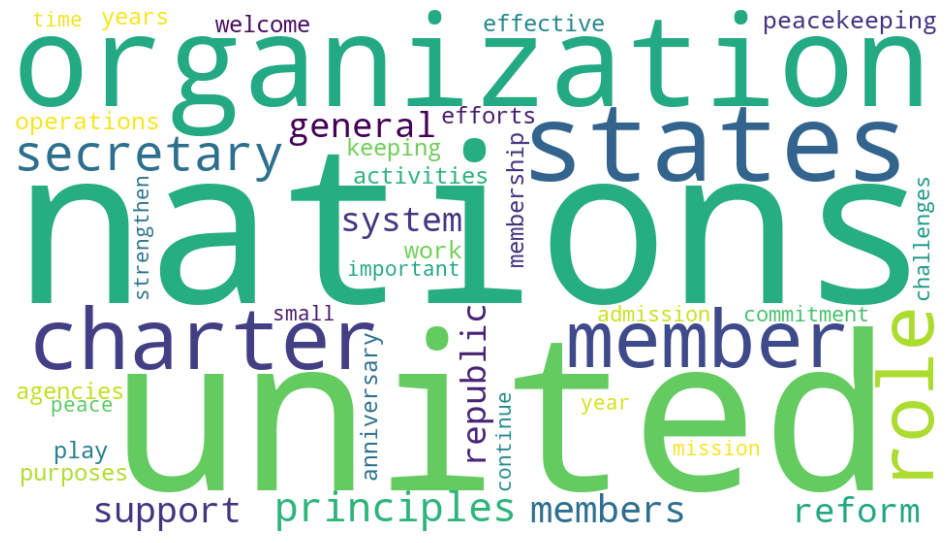

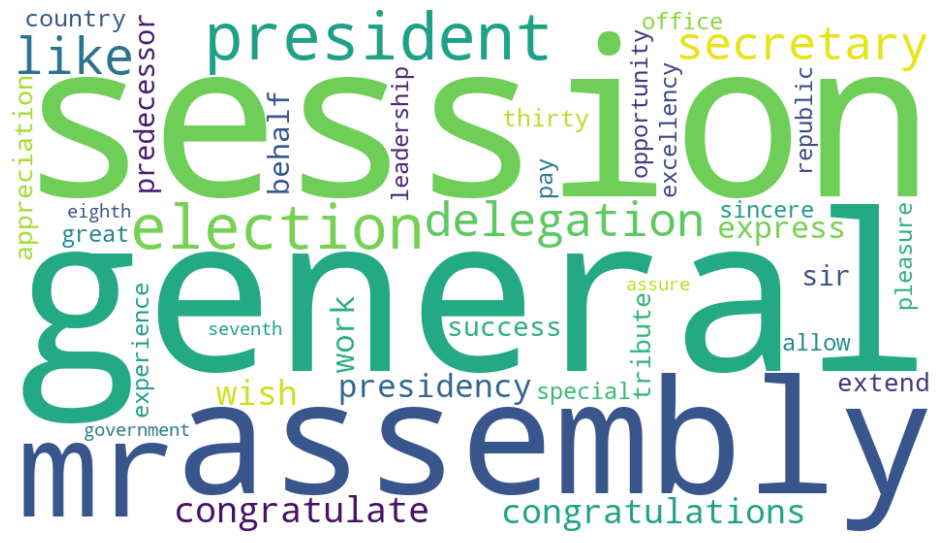

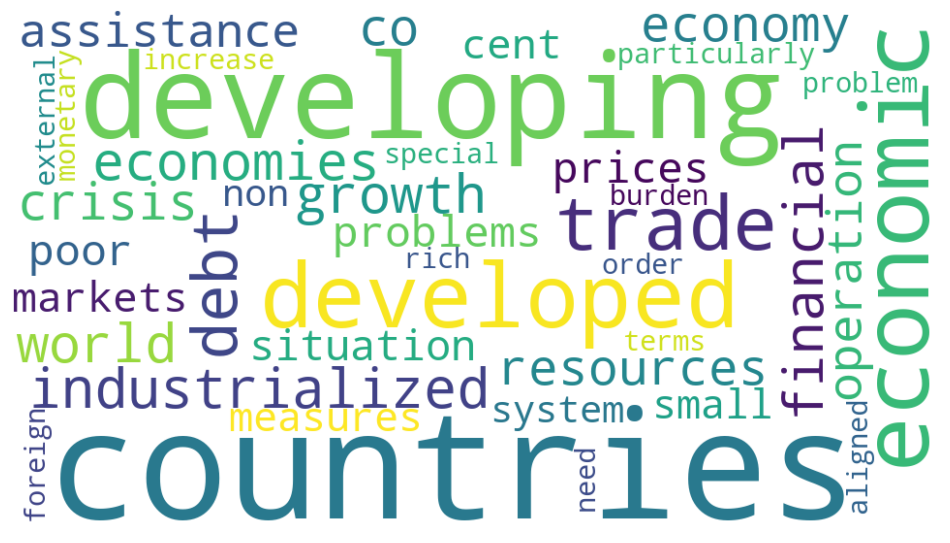

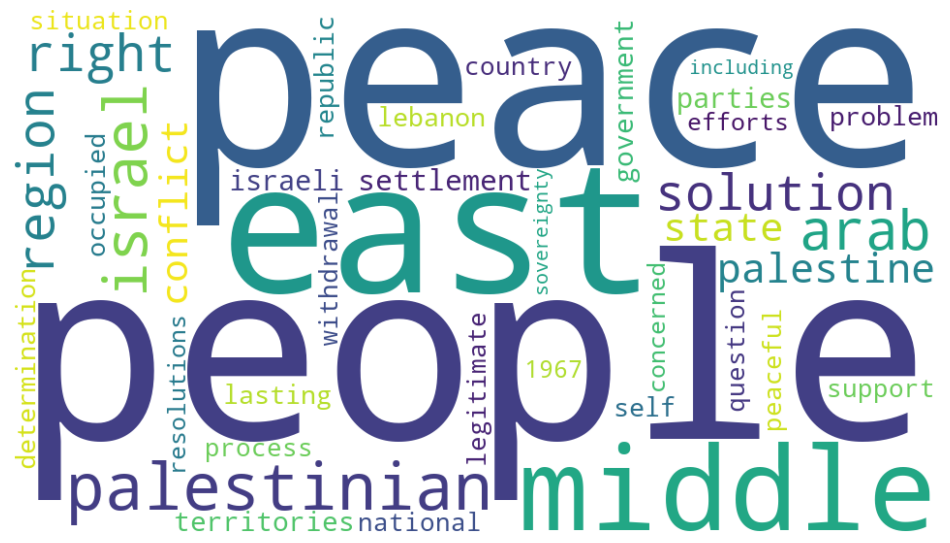

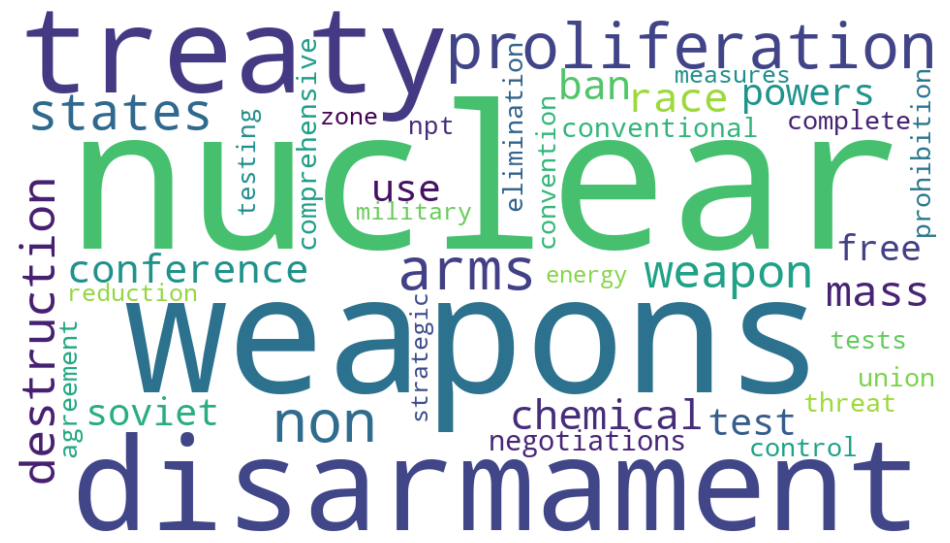

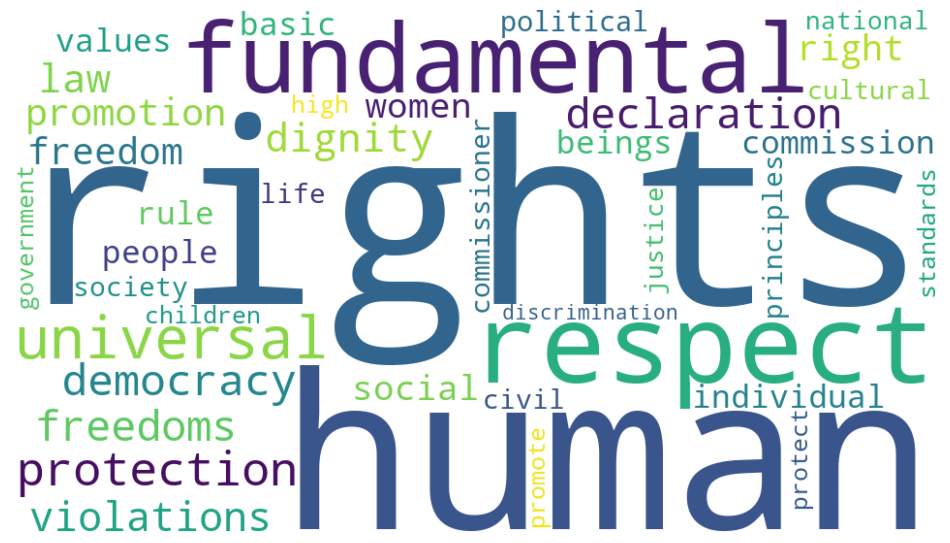

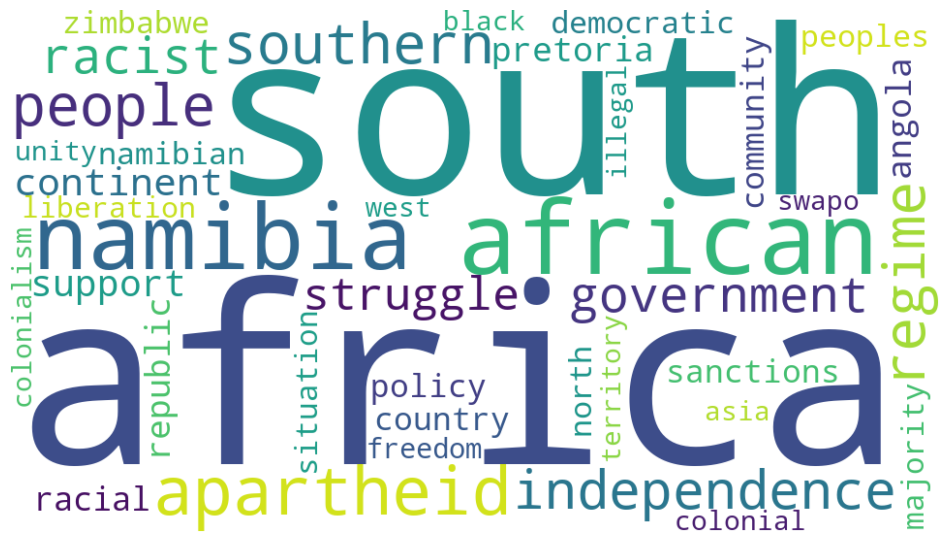

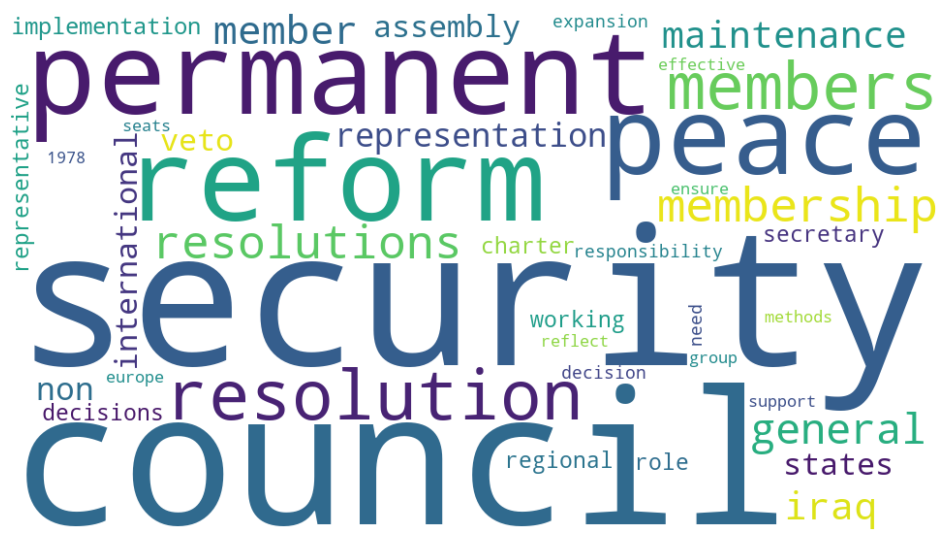

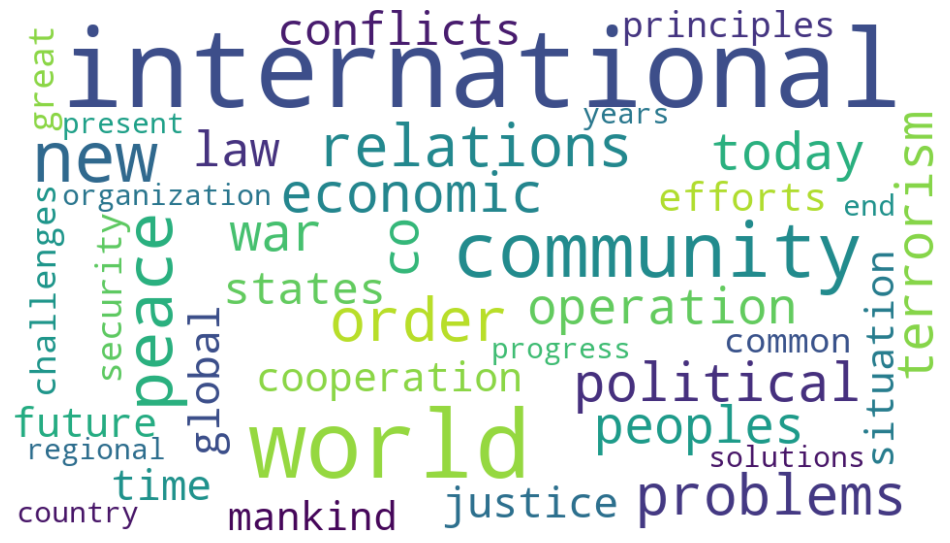

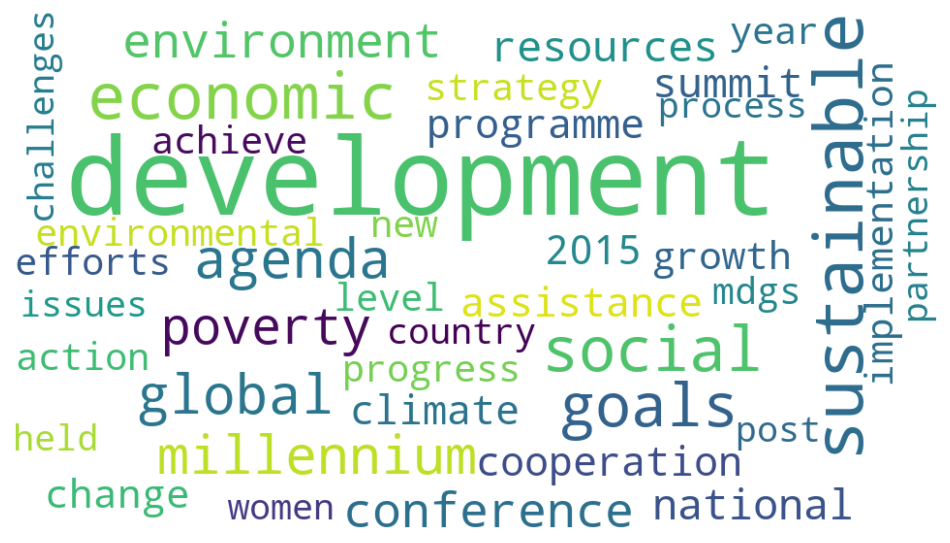

In [30]:
wordcloud_topics(nmf_para_model, tfidf_para_vectorizer.get_feature_names_out())

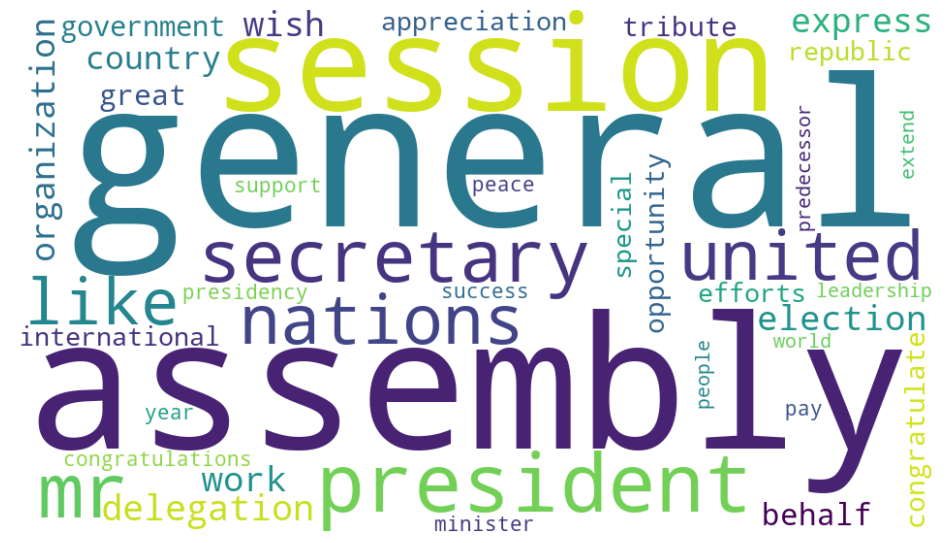

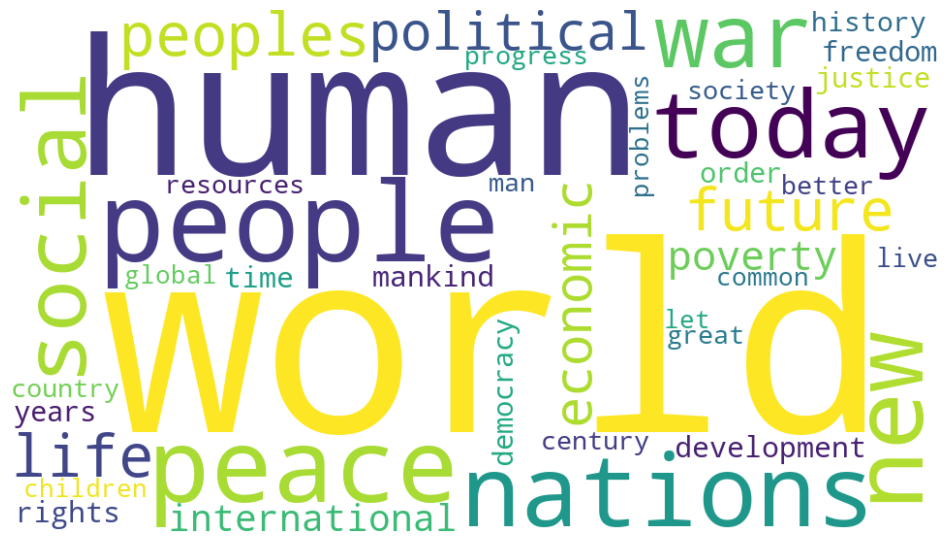

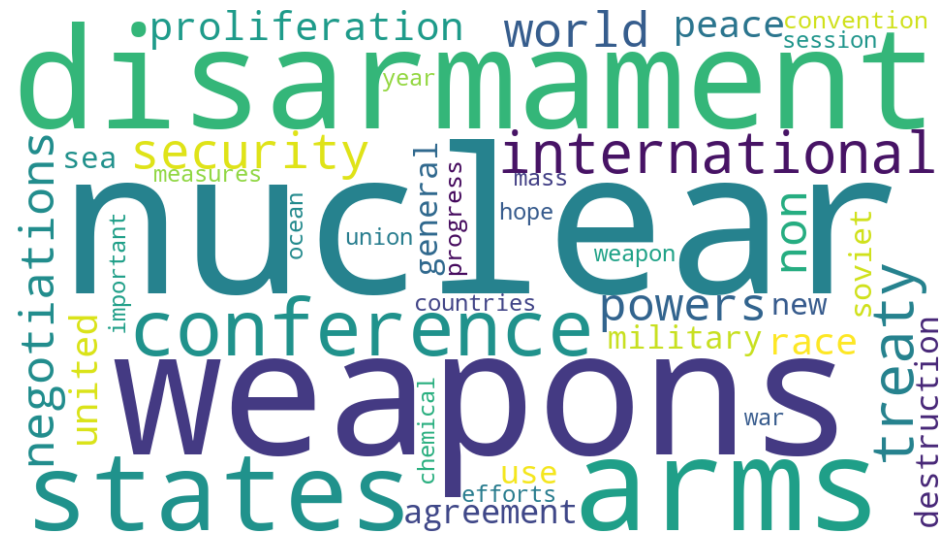

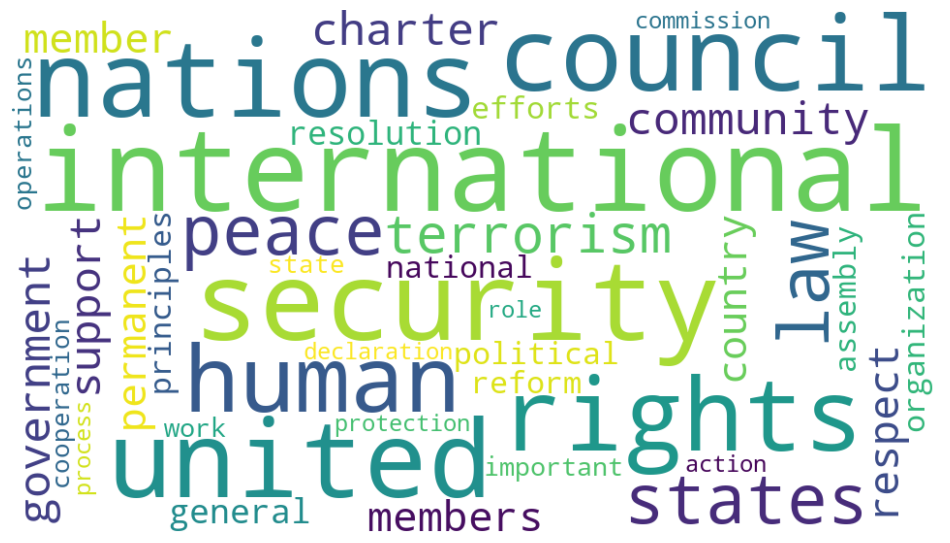

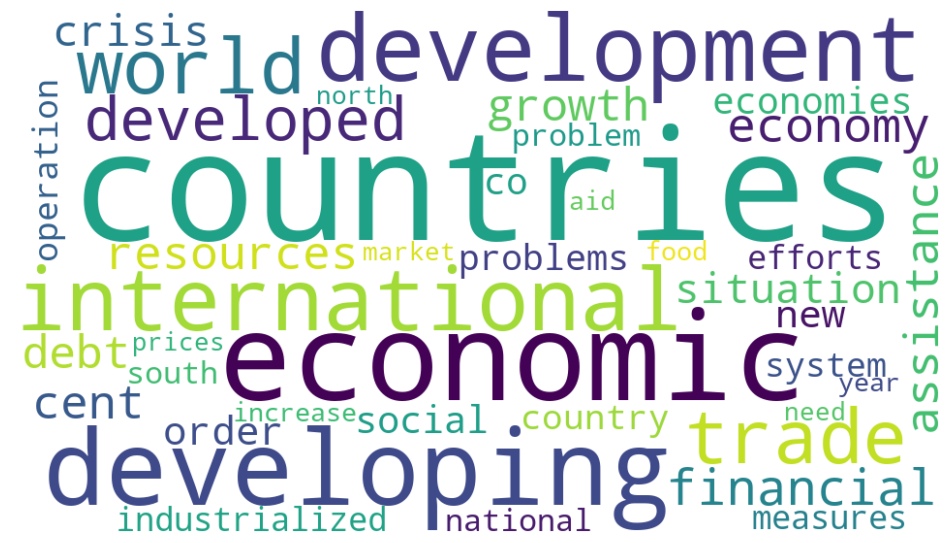

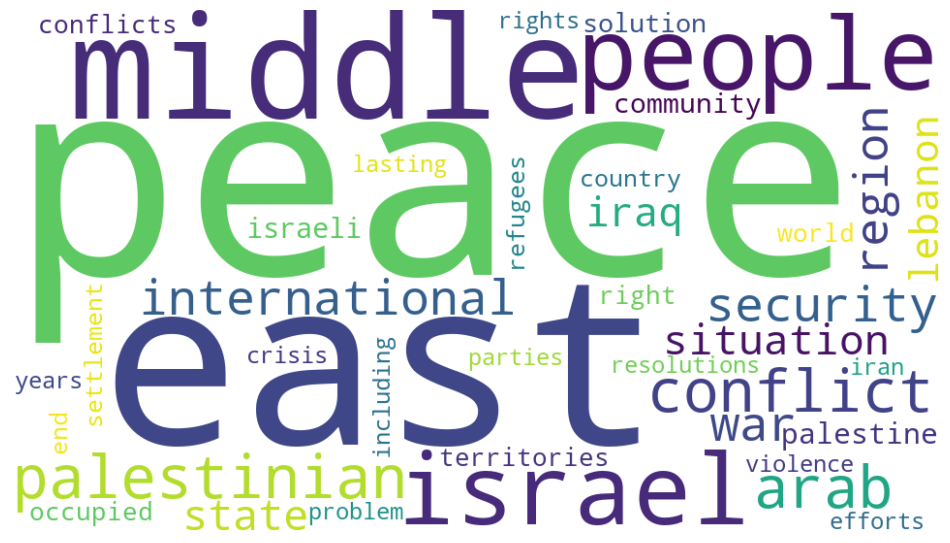

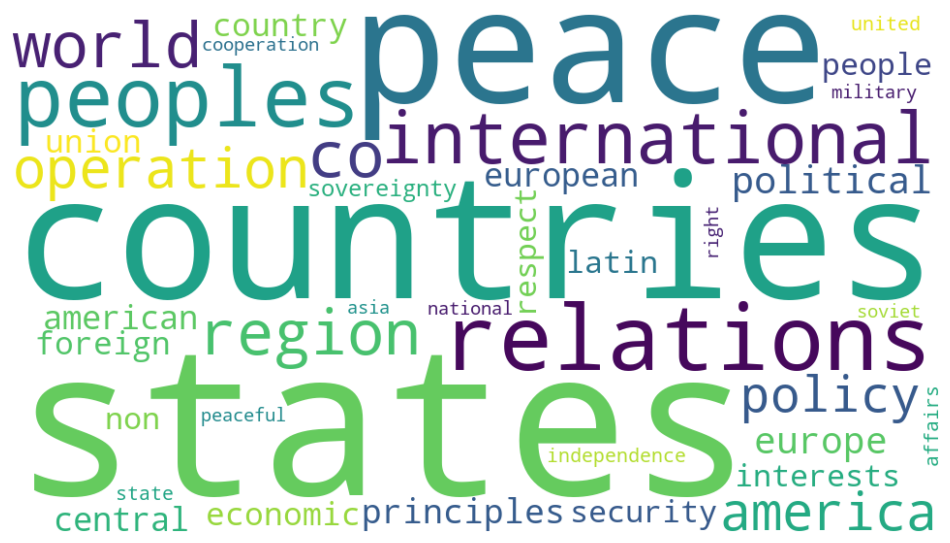

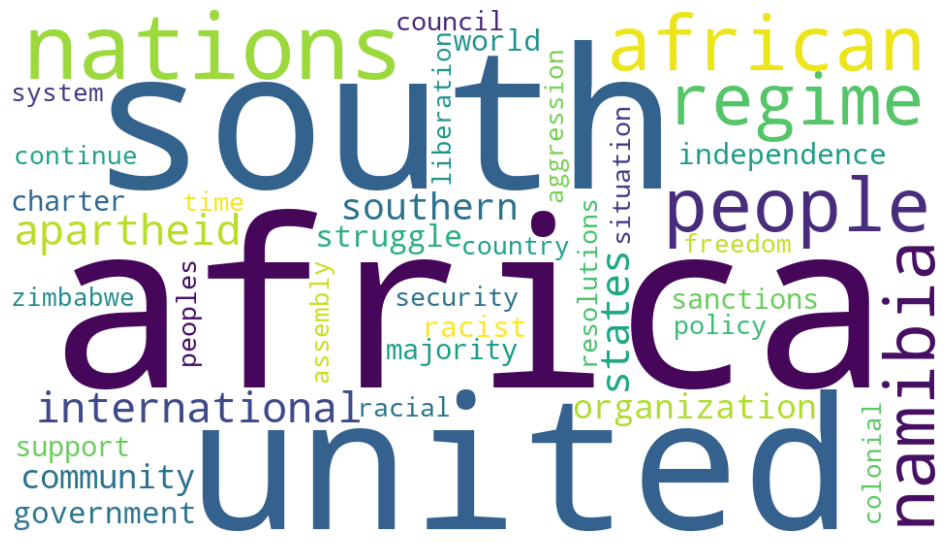

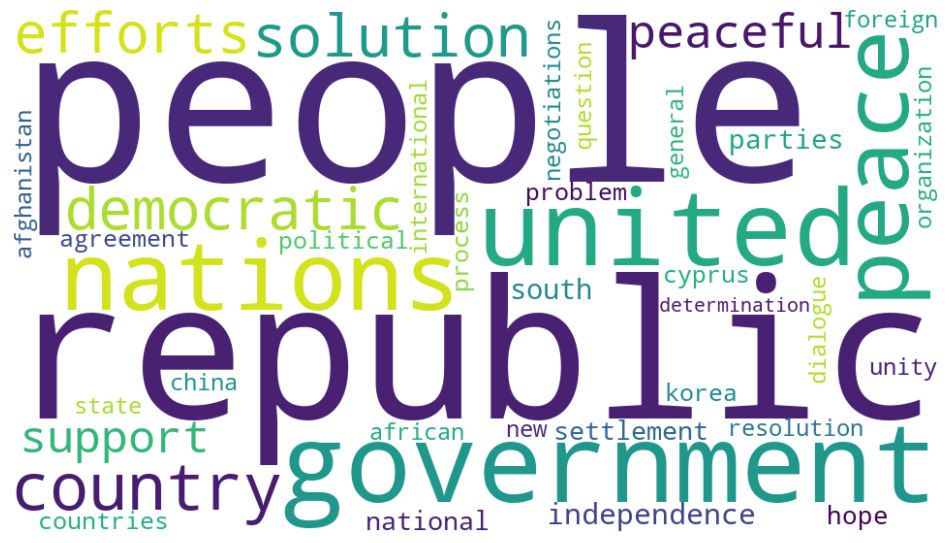

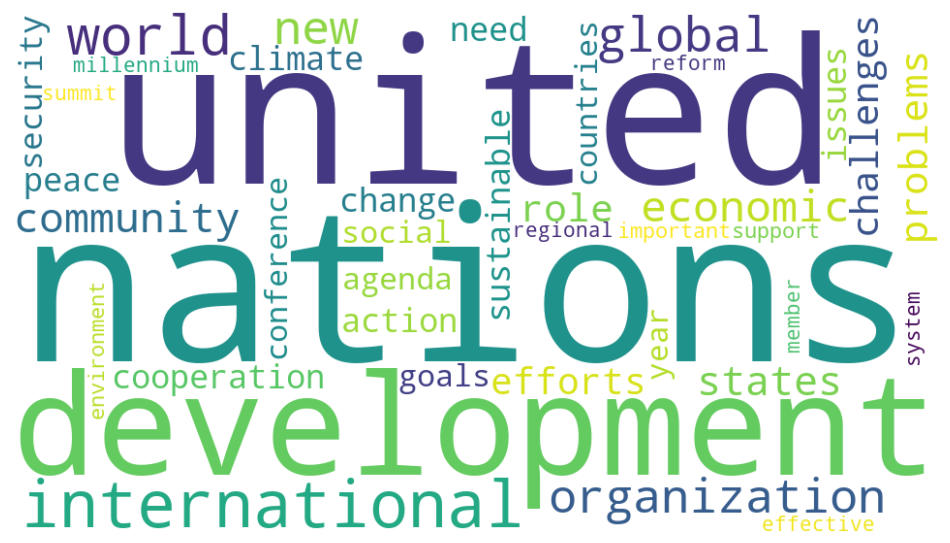

In [31]:
wordcloud_topics(lda_para_model, count_para_vectorizer.get_feature_names_out())

In [33]:
topic_names = []
voc = tfidf_para_vectorizer.get_feature_names_out()
for topic in nmf_para_model.components_:
    important = topic.argsort()
    top_word = voc[important[-1]] + " " + voc[important[-2]]
    topic_names.append("Topic " + top_word)

In [34]:
from tqdm.auto import tqdm
import numpy as np
year_data = []
for year in tqdm(np.unique(np.unique(paragraph_df["year"]))):
    W_year = nmf_para_model.transform(tfidf_para_vectors[np.array(paragraph_df["year"] == year)])
    year_data.append([year] + list(W_year.sum(axis=0)/W_year.sum()*100.0))

  0%|          | 0/46 [00:00<?, ?it/s]

<Axes: xlabel='year'>

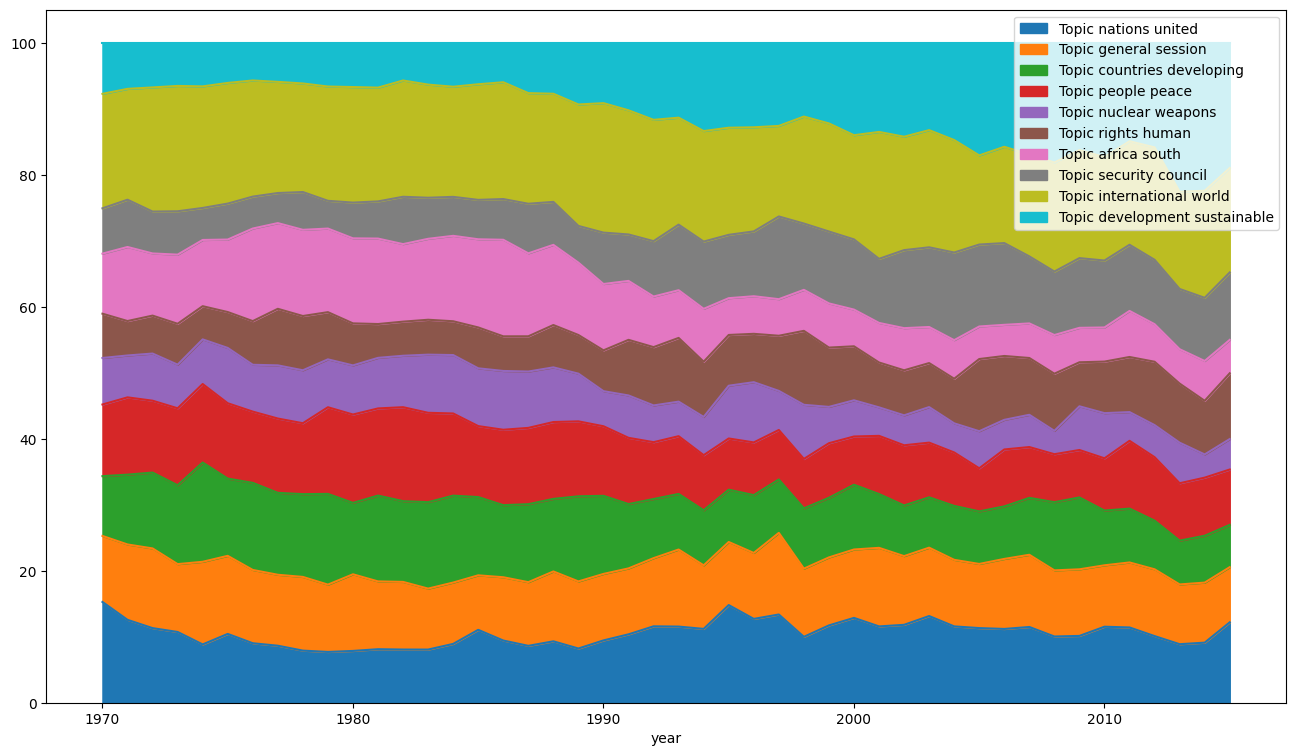

In [35]:
import matplotlib.pyplot as plt
df_year = pd.DataFrame(year_data, columns=["year"] +
topic_names).set_index("year")
df_year.plot.area(figsize=(16,9))

In [1]:
import pyLDAvis.sklearn
lda_display = pyLDAvis.sklearn.prepare(lda_para_model,
count_para_vectors, count_para_vectorizer, sort_topics=False)
pyLDAvis.display(lda_display)

"""
i can not find the solution for this. i tried to uninstall and install all libraries but its not working.
"""

ModuleNotFoundError: No module named 'pyLDAvis.sklearn'